## In this discussion, we will build a basic hybrid CNN-LSTM model for classification on the EEG dataset

#### This notebook was inspired to Tonmoy with some attempts to tune by us

## (i) Importing the necessary packages

In [158]:
import numpy as np
import pandas as pd
import keras
from keras import layers
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D, LayerNormalization, LSTM,BatchNormalization,MaxPooling2D,Reshape, Lambda, MultiHeadAttention
from keras.utils import to_categorical
import matplotlib.pyplot as plt

## (ii) Preprocessing the dataset and preparing the training, validation, and test datasets

In [159]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y



In [160]:
## Loading the dataset


X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769


## Random splitting and reshaping the data
# First generating the training and validation indices using random splitting

ind_valid = np.random.choice(2115, 375, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]


## Preprocessing the dataset
x_train,y_train = data_prep(X_train,y_train,2,2,True)
x_valid,y_valid = data_prep(X_valid,y_valid,2,2,True)
X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)


print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)
print('Shape of testing set:',X_test_prep.shape)
print('Shape of testing labels:',y_test_prep.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test_prep, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

keras.backend.clear_session()


Shape of X after trimming: (1740, 22, 500)
Shape of X after maxpooling: (1740, 22, 250)
Shape of X after averaging+noise and concatenating: (3480, 22, 250)
Shape of X after subsampling and concatenating: (6960, 22, 250)
Shape of X after trimming: (375, 22, 500)
Shape of X after maxpooling: (375, 22, 250)
Shape of X after averaging+noise and concatenating: (750, 22, 250)
Shape of X after subsampling and concatenating: (1500, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)
Shape of training set: (6960, 22, 250)
Shape of validation set: (1500, 22, 250)
Shape of training labels: (6960,)
Shape of validation labels: (1500,)
Shape of testing set: (1772, 22, 250)
Shape of testing labels: (1772,)
Shape of training labels after categorical conversion: (6960, 4)
Shape of validation labels after categorical conversion: (15

## (iii)(CNN-LSTM) Defining the architecture of the hybrid CNN-LSTM model

In [161]:
def spatial_attention(input):
    # Apply global average pooling along the channel axis
    average_pooling = keras.backend.mean(input, axis=3, keepdims=True)
    
    # Apply a convolutional layer to the input
    conv = Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(input)
    
    # Multiply the input by the convolutional layer
    multiplied = input * conv
    
    # Add the attention weight to the output of the global average pooling layer
    added = keras.backend.concatenate([average_pooling, multiplied], axis=3)
    
    # Reshape the output to match the shape of the input
    reshaped = Reshape((keras.backend.int_shape(input)[1], keras.backend.int_shape(input)[2],))(added)
    
    # Normalize the output using softmax
    softmax = keras.backend.softmax(reshaped, axis=1)
    
    # Multiply the input by the attention weight
    attention_mul = input * softmax
    
    return attention_mul

In [170]:
# Building the CNN model using functional class
def build_model():
# models = []
    num_heads = 4
    key_dim = 22//4
    n_frames = 250
    n_channels = 22
    # Conv. block 1
    In1 = keras.Input(shape =(250,1,22) )
    InAttention =  MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(In1,In1,In1)

    c1 = Conv2D(filters=25, kernel_size=(5,1), padding='same', activation='elu')(InAttention)
    p1 =  MaxPooling2D(pool_size=(5,1), padding='same')(c1) # Read the keras documentation
    b1 = BatchNormalization()(p1)
    d1 = Dropout(0.5)(b1)

    # Conv. block 2
    c2 = Conv2D(filters=50, kernel_size=(5,1), padding='same', activation='elu')(d1)
    p2 =  MaxPooling2D(pool_size=(5,1), padding='same')(c2) # Read the keras documentation
    b2 = BatchNormalization()(p2)
    d2 = Dropout(0.5)(b2)

    # Conv. block 3
    c3 = Conv2D(filters=100, kernel_size=(5,1), padding='same', activation='elu')(d2)
    p3 =  MaxPooling2D(pool_size=(5,1), padding='same')(c3) # Read the keras documentation
    b3 = BatchNormalization()(p3)
    d3 = Dropout(0.5)(b3)

    # Conv. block 4
    c4 = Conv2D(filters=200, kernel_size=(5,1), padding='same', activation='elu')(d3)
    p4 =  MaxPooling2D(pool_size=(5,1), padding='same')(c4) # Read the keras documentation
    b4 = BatchNormalization()(p4)
    d4 = Dropout(0.5)(b4)
    
    #attention
    # query_inputs = d4
    # key_inputs = d4
    # value_inputs = d4

    # a1 = MultiHeadAttention(num_heads=8, key_dim=200 // 8)(query_inputs, key_inputs, value_inputs)
    # a1 = LayerNormalization(epsilon=1e-6)(a1)
    # a1 = Flatten()(a1)
    # l1 = LSTM(10, dropout=0.6, recurrent_dropout=0.1, return_sequences=False)(a1)
    flatten = Flatten()(d4)
    reshape = Reshape((-1, np.prod(d4.shape[2:]))) (flatten)
    lstm1 = LSTM(64, return_sequences=True)(reshape)
    attention1 = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(lstm1,lstm1,lstm1)
    residual1 = lstm1 + attention1
    lstm2 = LSTM(64, return_sequences=True)(residual1)
    attention2 = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(lstm2,lstm2,lstm2)
    residual2 = lstm2 + attention2
    flatten2 = (Flatten())(residual2)
    dense1 = Dense(128, activation='relu')(flatten2)
    dropout1 = Dropout(0.5)(dense1)
    dense2 = Dense(4, activation='softmax')(dropout1)

    # Add fully connected layers
    
    # fc2 = Dense(4, activation='softmax')(dense2)

    # Define the final model
    final_model = Model(inputs=In1, outputs=[dense2])

    # Compile the final model
    # # # Apply spatial attention
    # # hybrid_cnn_lstm_model.add(Lambda(spatial_attention))

    

    # # FC 
    # hybrid_cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
    # hybrid_cnn_lstm_model.add(Dense(100, activation='Elu')) # FC layer with 100 units
    # hybrid_cnn_lstm_model.add(Reshape((100,1))) # Reshape my output of FC layer so that it's compatible
    # # hybrid_cnn_lstm_model.add(LSTM(10, dropout=0.6, recurrent_dropout=0.1, input_shape=(200,1), return_sequences=False))


    # # Output layer with Softmax activation 
    # hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

    # # models.append(hybrid_cnn_lstm_model)
    # # Printing the model summary
    final_model.summary()
    return final_model

## (iv)(CNN-LSTM) Defining the hyperparameters of the hybrid CNN-LSTM model

In [171]:
# Model parameters
learning_rate = 1e-3
epochs = 100
hybrid_cnn_lstm_optimizer = keras.optimizers.Adam(lr=learning_rate)

## (v)Attention at the end

In [174]:
# Compiling the model
keras.backend.clear_session()

# Training and validating the model

batch_sizes = [32,64,128]
import matplotlib.pyplot as plt

hybrid_cnn_lstm_model = build_model()
# Compiling the model
hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy',
               optimizer=hybrid_cnn_lstm_optimizer,
               metrics=['accuracy'])

# Training and validating the model

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(x_train,
                y_train,
                batch_size=32,
                epochs=epochs,
                validation_data=(x_valid, y_valid), 
                verbose=True,
                callbacks = [callback]
                )

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 1, 22)  0           []                               
                                ]                                                                 
                                                                                                  
 multi_head_attention (MultiHea  (None, 250, 1, 22)  1842        ['input_1[0][0]',                
 dAttention)                                                      'input_1[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 250, 1, 25)   2775        ['multi_head_attention[0][0]'

## (vi)(CNN-Attention) Visualizing the accuracy and loss trajectory

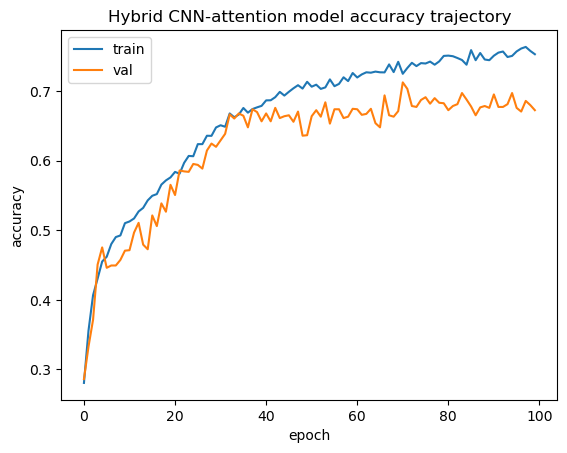

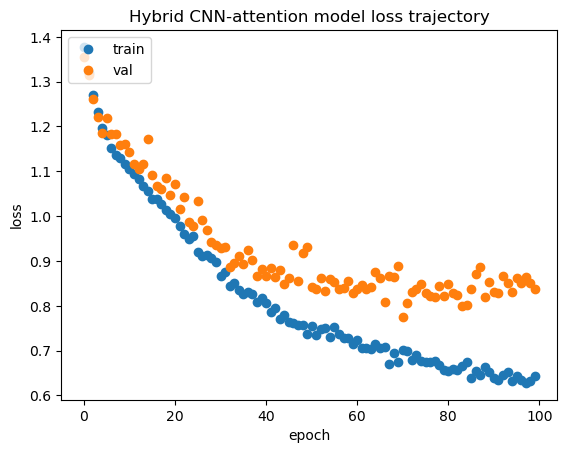

In [165]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['accuracy'])
plt.plot(hybrid_cnn_lstm_model_results.history['val_accuracy'])
plt.title('Hybrid CNN-attention model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['loss'],'o')
plt.plot(hybrid_cnn_lstm_model_results.history['val_loss'],'o')
plt.title('Hybrid CNN-attention model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## (vii)(CNN-LSTM) Testing the performance of the hybrid CNN-LSTM model on the held out test set

In [166]:
## Testing the hybrid CNN-LSTM model

hybrid_cnn_lstm_score = hybrid_cnn_lstm_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN-attention model:',hybrid_cnn_lstm_score[1])

Test accuracy of the hybrid CNN-attention model: 0.6568848490715027
